In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos
import sw_and_int_one_sess as sios

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_disinhibition_cosw'
figdir = misc.get_or_create_subdir(figdir)

In [4]:
fn = 'prepped_data_agg.p'
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [5]:
import switch_detection_sweep_penalty_one_session as sdspos
import get_all_switch_add_metrics_pen as gasamp
reload(gasamp)
pen=0.5#0.3#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}
all_sw_d_all={}
all_sw_with_metrics_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    
    sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
    if sw_info_res_pelt is None:
        sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res_pelt['all_sw_d_pen'][pen]
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res_pelt['all_sw_with_metrics_d_pen'][pen]
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d
    
    all_sw_res= gasamp.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

all_sw_d_all=pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info_pe

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/all_sw_info_pen.p exist

In [6]:
import sw_and_int_withreg as saiw
reload(saiw)

import peer_prediction as pp
reload(sios)
consec_trial_fr_diff_all = {}
sustained_all = {}
transient_all={}
all_sw_with_inh_change_all = {}
glm_res_df_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_and_int_res=saiw.main(data_dir_full,force_reload=False,load_only=True)
    consec_trial_fr_diff=sw_and_int_res['consec_trial_fr_diff_all']
    sustained=sw_and_int_res['sustained']
    transient =sw_and_int_res['transient']
    consec_trial_fr_diff_all[ani,sess] = consec_trial_fr_diff
    sustained_all[ani,sess] = sustained
    transient_all[ani,sess] = transient
    
    all_sw_with_inh_change = sw_and_int_res['all_sw_with_metrics_oneti_with_inh_change']
    all_sw_with_inh_change_all[ani,sess]=all_sw_with_inh_change
    
    glm_res_df = sw_and_int_res['glm_res_df']
    glm_res_df_all[ani,sess] = glm_res_df



glm_res_df_all = pd.concat(glm_res_df_all,axis=0)
all_sw_with_inh_change_all=pd.concat(all_sw_with_inh_change_all,axis=0)
    
consec_trial_fr_diff_all = pd.concat(consec_trial_fr_diff_all,axis=0)
sustained_all = pd.concat(sustained_all,axis=0)
transient_all = pd.concat(transient_all,axis=0)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/sw_and_int_exclude_sw_large

In [18]:
# all_sw_with_inh_change_one =  all_sw_with_inh_change_all.loc[(slice(None),sess),:]

In [20]:
# sw = 1
# all_sw_with_inh_change_one_sw = all_sw_with_inh_change_one.query('switch==@sw')

In [24]:
# changes_df_one = changes_df_all.loc[(slice(None),sess),:]

# baseline: if share place field, do share int?

In [30]:
print(sess_l)

Index(['e13_26m1_210913', 'e15_13f1_220117', 'e15_13f1_220118',
       'e15_13f1_220119', 'e15_13f1_220120', 'e13_26m1_211019',
       'e13_16f1_210328', 'e13_26m1_211116', 'e16_3m2_211213',
       'e16_3m2_211212', 'e16_3m1_210203', 'e16_3m2_211210', 'e13_26m1_211119',
       'e13_26m1_211124', 'e16_3m1_210201', 'e13_16f1_210331',
       'e16_3m1_210119', 'e13_16f1_210302', 'e13_16f1_210317',
       'e13_16f1_210312', 'e15_10m1_200809', 'e15_10m1_200812',
       'e13_16f1_210314', 'e15_9f1_200729', 'e14_2m2_201019',
       'e13_16f1_210319', 'e13_16f1_210322', 'e15_10m1_200727',
       'e14_2m2_201017', 'e16_1f1_201004', 'e16_1f1_200920', 'e15_9f1_200723',
       'e14_2m3_201129', 'e14_2m3_201125', 'e16_1f1_200918', 'e16_1f1_200919',
       'e14_2m3_201208', 'e14_2m3_201206', 'e15_9f1_200802', 'e16_1f1_200923',
       'e15_9f1_200720', 'e16_2m1_201121', 'e15_10m1_200803', 'e15_9f1_200715',
       'e14_2m3_201121', 'e14_2m3_201118'],
      dtype='object')


In [31]:
ani='e15_13f1'
sess_l = all_sw_with_inh_change_all.index.get_level_values(1).unique()
sess = 'e15_13f1_220118'#sess_l[1]

all_fields_recombined_one = all_fields_recombined_all.loc[ani,sess]

/tmp/ipykernel_805716/2456122114.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_recombined_one = all_fields_recombined_all.loc[ani,sess]


In [32]:
import pairwise_analysis as pwa

In [41]:
val_

start end com peak    fr_peak   fr_mean  other_field_index
    field_index                                                           
39  0               2  11   5    2   7.412784  5.762076                NaN
    1              17  41  30   35   7.208522  4.871449                NaN
40  0               5  34  19   17  11.676867  8.178727                NaN
42  0               2  27  11    5  12.384649  8.869572                NaN
46  0              13  20  16   17   6.370133  6.058965                NaN
...               ...  ..  ..  ...        ...       ...                ...
351 0              20  25  22   23   1.320895  1.164134                NaN
352 0              24  38  30   31  15.745478   9.45535                NaN
353 0              38  46  41   42    1.32418  1.012957                NaN
354 0              14  28  20   21  14.825625  9.779709                NaN
358 1              44  48  46   48   1.393638  1.141564                NaN

[185 rows x 7 columns]

In [44]:
gpb = all_fields_recombined_one.groupby(level=0)
# tt_all = all_fields_recombined_one.index.get_level_values(1).unique()
pf_overlap = {}

for ti, val in gpb:
    commonway = True
    tt_all = val.index.get_level_values(1).unique()
    if 'both' in tt_all:
        has_both = True
    else:
        has_both=False

    for tt in [0,1]:
        if has_both:
            tt_l = [tt,'both']
            if tt==1: # need to reindex the both
                val_both =copy.copy(val.loc[(ti,'both')])
                new_ind = all_fields_recombined_one.loc[ti,'both'].loc[val_both.index].reset_index(level=1,drop=True).set_index('other_field_index',append=True).index
                val_both.index=new_ind
                val_ = pd.concat({(ti,tt):val.loc[(ti,tt)],
                                 (ti,'both'):val_both
                                },axis=0)
                commonway=False
            else:
                commonway=True
                
        else:
            tt_l = [tt]
            commonway = True

        if commonway:
            val_ = val.loc[(ti,tt_l),:]
        pf_overlap[(ti,tt)]=pwa.get_field_overlap_pair(val_,uid=val_.index.get_level_values(2))
pf_overlap = pd.concat(pf_overlap,axis=0)



/mnt/home/szheng/projects/util_code/pairwise_analysis.py:111: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ind_pair_tensor[:,:,0] = np.tile(uid[:,None],[1,n_field])
/mnt/home/szheng/projects/util_code/pairwise_analysis.py:112: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ind_pair_tensor[:,:,1] = np.tile(uid[None,:],[n_field,1])
/mnt/home/szheng/projects/util_code/pairwise_analysis.py:111: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ind_pair_tensor[:,:,0] = np.tile(uid[:,None],[1,n_field])
/mnt/home/szheng/projects/util_code/pairwise_analysis.py:112: FutureWarning: Support for

In [48]:
glm_res_df = glm_res_df_all.loc[ani,sess].dropna(axis=1,how='all')

/tmp/ipykernel_805716/2189080456.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  glm_res_df = glm_res_df_all.loc[ani,sess].dropna(axis=1,how='all')


In [34]:

from scipy.spatial.distance import pdist, squareform

In [49]:
# jaccard for inhibition
glm_res_per_uid = glm_res_df.groupby(level=(0,1)).mean()
int_that_inh=(glm_res_per_uid['coef'] < 0) & (glm_res_per_uid['p'] < 0.05)

int_that_inh_sim = 1-squareform(pdist(int_that_inh,metric='jaccard'))

int_that_inh_sim = pd.DataFrame(int_that_inh_sim,index=glm_res_per_uid.index,columns=glm_res_per_uid.index)

In [179]:
#corr
coef = glm_res_df['coef']
coef_per_uid = coef.groupby(level=(0,1)).mean()
glmcoef_sim = np.corrcoef(coef_per_uid)
glmcoef_sim = pd.DataFrame(glmcoef_sim,index=coef_per_uid.index,columns=coef_per_uid.index)

In [180]:
reload(pwa)
int_con_sim = glmcoef_sim#int_that_inh_sim

ti=0
for tt in [0,1]:
    if has_both:
        tt_l = [tt,'both']
    else:
        tt_l = tt
    int_con_sim_onett=int_con_sim.loc[(tt_l,slice(None)),(tt_l,slice(None))]
    int_con_sim_onett=int_con_sim_onett.groupby(level=1,axis=0).mean().groupby(level=1,axis=1).mean()
#     int_con_sim_onett = int_con_sim_onett.droplevel(0,axis=0).droplevel(0,axis=1)
    
    pf_overlap_onett = pf_overlap.loc[ti,tt].dropna(axis=1,how='all')
    
    diff, pf_overlap_onett_flatten, int_con_sim_onett_flatten = pwa.label_difference_grouped_by_coswitch(pf_overlap_onett,int_con_sim_onett)
    
    

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

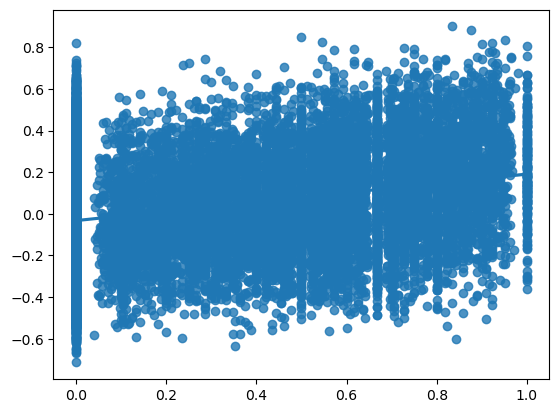

In [181]:
sns.regplot(pf_overlap_onett_flatten,int_con_sim_onett_flatten)

In [168]:
all_sw_with_inh_change_one = all_sw_with_inh_change_all.loc[ani,sess].query('selected_inh_fr_change<0')

/tmp/ipykernel_805716/1981710810.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_inh_change_one = all_sw_with_inh_change_all.loc[ani,sess].query('selected_inh_fr_change<0')


In [169]:
# sw_sim_allonoff, time_diff_allonoff = pwa.get_sw_sim(all_sw_with_inh_change_one,diff_key='time',win_l=[1,30],decay_rate_l=[])
sw_sim_allonoff, time_diff_allonoff = pwa.get_sw_sim(all_sw_with_inh_change_one,diff_key='field_pos',win_l=[5],decay_rate_l=[])



In [170]:
# reload(pwa)
# sw = 1
# int_con_sim = int_that_inh_sim
# # for tt in [0,1]:
# for tt in [0]:
#     if has_both:
#         tt_l = [tt,'both']
#     else:
#         tt_l = tt
    
#     sw_sim_onett_peruid = sw_sim_allonoff.loc[sw,'within_5'].dropna(axis=1,how='all')
    
#     int_con_sim_onett=int_con_sim.loc[(tt_l,slice(None)),(tt_l,slice(None))]
#     int_con_sim_onett=int_con_sim_onett.groupby(level=1,axis=0).mean().groupby(level=1,axis=1).mean()
# #     int_con_sim_onett = int_con_sim_onett.droplevel(0,axis=0).droplevel(0,axis=1)
    
#     pf_overlap_onett = pf_overlap.loc[ti,tt].dropna(axis=1,how='all')
    
#     diff, pf_overlap_onett_flatten, int_con_sim_onett_flatten = pwa.label_difference_grouped_by_coswitch(pf_overlap_onett,int_con_sim_onett)
#     diff, int_con_sim_onett_flatten_sw,sw_sim_onett_peruid_flatten  = pwa.label_difference_grouped_by_coswitch(int_con_sim_onett,sw_sim_onett_peruid)
    
    
#     pf_overlap_onett_binary = pf_overlap_onett > 0.5
#     diff_pf, int_con_sim_onett_flatten,pf_bin_flatten  = pwa.label_difference_grouped_by_coswitch(int_con_sim_onett,pf_overlap_onett_binary)
    
    
    
    

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [171]:
# mat = int_con_sim_onett.loc[index_intersect,index_intersect].values
# ma=pf_overlap_onett_binary.loc[index_intersect,index_intersect].values
# ma = np.triu(ma,1)
# mat[ma]
# pair1,pair2=np.nonzero(ma)
# ind_pairs = index_intersect[pair1],index_intersect[pair2]

In [131]:
def get_overlap_and_co_sw_not_co_sw_inds(all_sw_with_inh_change_one,sw,tt):
    all_sw_with_inh_change_one_onoff = all_sw_with_inh_change_one.query('switch==@sw&(trialtype==@tt|trialtype=="both")')
    uid_l = all_sw_with_inh_change_one_onoff['uid'].values
    field_dist = all_sw_with_inh_change_one_onoff['field_pos'].values[:,None] - all_sw_with_inh_change_one_onoff['field_pos'].values[None,:]
    field_dist=np.abs(field_dist)
    dist_thresh = 10
    field_dist_binary =field_dist < dist_thresh

    trialtype_match = all_sw_with_inh_change_one_onoff['trialtype'].values[:,None] == all_sw_with_inh_change_one_onoff['trialtype'].values[None,:]
    trialtype_match[(all_sw_with_inh_change_one_onoff['trialtype']=='both').values] = True
    trialtype_match[:,(all_sw_with_inh_change_one_onoff['trialtype']=='both').values] = True

    field_dist_binary = np.logical_and(field_dist_binary,trialtype_match)


    field_dist_binary = np.triu(field_dist_binary,1)
    ind1,ind2=np.nonzero(field_dist_binary)
    overlap_and_sw_ind = np.stack([uid_l[ind1],uid_l[ind2]]).T

    trial_ind_dist =all_sw_with_inh_change_one_onoff['trial_index'].values[:,None] - all_sw_with_inh_change_one_onoff['trial_index'].values[None,:]
    trial_dist_thresh=0
    trial_ind_dist_binary = np.abs(trial_ind_dist) <=trial_dist_thresh
    trial_ind_dist_binary = np.triu(trial_ind_dist_binary,1)

    overlap_and_co_sw = np.logical_and(field_dist_binary,  trial_ind_dist_binary)
    overla_and_sw_not_co = np.logical_and(field_dist_binary,  ~trial_ind_dist_binary)

    ind1,ind2=np.nonzero(overlap_and_co_sw)
    overlap_and_co_sw_ind = np.stack([uid_l[ind1],uid_l[ind2]]).T

    ind1,ind2=np.nonzero(overla_and_sw_not_co)
    overlap_and_sw_not_co_ind = np.stack([uid_l[ind1],uid_l[ind2]]).T


    return overlap_and_co_sw_ind,overlap_and_sw_not_co_ind
    # overlap_and_co_sw_ind = 




In [127]:
# all_sw_with_inh_change_one_onoff = all_sw_with_inh_change_one.query('switch==1&(trialtype==@tt|trialtype=="both")')
# uid_l = all_sw_with_inh_change_one_onoff['uid'].values
# field_dist = all_sw_with_inh_change_one_onoff['field_pos'].values[:,None] - all_sw_with_inh_change_one_onoff['field_pos'].values[None,:]
# field_dist=np.abs(field_dist)
# dist_thresh = 10
# field_dist_binary =field_dist < dist_thresh

# trialtype_match = all_sw_with_inh_change_one_onoff['trialtype'].values[:,None] == all_sw_with_inh_change_one_onoff['trialtype'].values[None,:]
# trialtype_match[(all_sw_with_inh_change_one_onoff['trialtype']=='both').values] = True
# trialtype_match[:,(all_sw_with_inh_change_one_onoff['trialtype']=='both').values] = True

# field_dist_binary = np.logical_and(field_dist_binary,trialtype_match)


# field_dist_binary = np.triu(field_dist_binary,1)
# ind1,ind2=np.nonzero(field_dist_binary)
# overlap_and_sw_ind = np.stack([uid_l[ind1],uid_l[ind2]]).T

# trial_ind_dist =all_sw_with_inh_change_one_onoff['trial_index'].values[:,None] - all_sw_with_inh_change_one_onoff['trial_index'].values[None,:]
# trial_dist_thresh=0
# trial_ind_dist_binary = np.abs(trial_ind_dist) <=trial_dist_thresh
# trial_ind_dist_binary = np.triu(trial_ind_dist_binary,1)

# overlap_and_co_sw = np.logical_and(field_dist_binary,  trial_ind_dist_binary)
# overla_and_sw_not_co = np.logical_and(field_dist_binary,  ~trial_ind_dist_binary)

# ind1,ind2=np.nonzero(overlap_and_co_sw)
# overlap_and_co_sw_ind = np.stack([uid_l[ind1],uid_l[ind2]]).T

# ind1,ind2=np.nonzero(overla_and_sw_not_co)
# overlap_and_sw_not_co_ind = np.stack([uid_l[ind1],uid_l[ind2]]).T



# # overlap_and_co_sw_ind = 



In [182]:
sw = 1
int_con_sim = glmcoef_sim#int_that_inh_sim
for tt in [0,1]:
    if has_both:
        tt_l = [tt,'both']
    else:
        tt_l = tt
    
    sw_sim_onett_peruid = sw_sim_allonoff.loc[sw,'within_5'].dropna(axis=1,how='all')
    
    int_con_sim_onett=int_con_sim.loc[(tt_l,slice(None)),(tt_l,slice(None))]
    int_con_sim_onett=int_con_sim_onett.groupby(level=1,axis=0).mean().groupby(level=1,axis=1).mean()
    
    
    overlap_and_cosw_ind,overlap_and_sw_not_co_ind=get_overlap_and_co_sw_not_co_sw_inds(all_sw_with_inh_change_one,sw,tt)

In [173]:
def intersect_then_index(df,ind,axis=0):
    if axis==0:
        ind_ = df.index.intersection(ind)
        subdf=df.loc[ind_]
    else:
        ind_ = df.columns.intersection(ind)
        subdf = df.loc[:,ind_]
    return subdf
        

In [183]:
subdf = intersect_then_index(int_con_sim_onett,overlap_and_cosw_ind[:,0],axis=0)
int_con_sim_onett_overlap_and_cosw = intersect_then_index(subdf,overlap_and_cosw_ind[:,1],axis=1)

subdf = intersect_then_index(int_con_sim_onett,overla_and_sw_not_co_ind[:,0],axis=0)
int_con_sim_onett_overlap_and_sw_not_co = intersect_then_index(subdf,overla_and_sw_not_co_ind[:,1],axis=1)





In [184]:
int_con_sim_onett_grouped=pd.concat({0:int_con_sim_onett_overlap_and_sw_not_co.unstack(),
1:int_con_sim_onett_overlap_and_cosw.unstack()}).reset_index(level=0)
int_con_sim_onett_grouped.columns=['cosw','int_con_sim']

In [265]:
sw=-1
# all_sw_with_inh_change_one = all_sw_with_inh_change_all.loc[ani,sess].query('selected_inh_fr_change<0')
all_sw_with_inh_change_one = all_sw_with_inh_change_all.loc[ani,sess].query('selected_inh_fr_change>0')

/tmp/ipykernel_805716/3043689016.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_inh_change_one = all_sw_with_inh_change_all.loc[ani,sess].query('selected_inh_fr_change>0')


In [268]:
reload(pwa)

int_con_sim_onett_grouped_bothtt = pwa.get_int_con_group_by_overlap_and_cosw(int_con_sim,all_sw_with_inh_change_one,sw=sw)



xx=int_con_sim_onett_grouped_bothtt.query('cosw=="cosw"')['int_con_sim']
yy=int_con_sim_onett_grouped_bothtt.query('cosw=="no_cosw"')['int_con_sim']
# u_stat,pval=scipy.stats.ranksums(xx,yy)
scipy.stats.ttest_ind(xx,yy)





Ttest_indResult(statistic=0.583671599100079, pvalue=0.5609869298326486)

In [266]:
import test_co_switch as tcs
changes_df = changes_df_all.loc[ani,sess]

ti=0
all_sw_with_inh_change_one['task_ind']=ti
inds=pd.MultiIndex.from_frame(all_sw_with_inh_change_one[['task_ind','trialtype','uid','field_index']])
changes_df = changes_df.loc[inds]

pf_params_recombined=pf_params_recombined_all.loc[ani,sess]
spk_beh_df = spk_beh_df_all.loc[(ani,sess),:].query('task_index==@ti')



/tmp/ipykernel_805716/1400904051.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = changes_df_all.loc[ani,sess]
/tmp/ipykernel_805716/1400904051.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  pf_params_recombined=pf_params_recombined_all.loc[ani,sess]
/tmp/ipykernel_805716/1400904051.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  spk_beh_df = spk_beh_df_all.loc[(ani,sess),:].query('task_index==@ti')


In [267]:
%%time
cosw_shuffle_res=tcs.gen_circular_shuffle_trialtype_seperated_get_all_sw(changes_df,pf_params_recombined,spk_beh_df,nrepeats=100,min_cpd_win=2)
all_sw_shuffle = cosw_shuffle_res['all_sw']
u_stat_sh_l = []
pval_sh_l = []
for all_sw_sh in all_sw_shuffle:
    ind=pd.MultiIndex.from_frame(all_sw_with_inh_change_one[['trialtype','uid','field_index']])
    all_sw_shuffle_preocessed=all_sw_sh.loc[ti].set_index(['trialtype','uid','field_index']).loc[ind].reset_index()
    
    int_con_sim_onett_grouped_bothtt_sh = pwa.get_int_con_group_by_overlap_and_cosw(int_con_sim,all_sw_shuffle_preocessed,sw=sw)
    xx=int_con_sim_onett_grouped_bothtt_sh.query('cosw=="cosw"')['int_con_sim']
    yy=int_con_sim_onett_grouped_bothtt_sh.query('cosw=="no_cosw"')['int_con_sim']
#     u_stat_sh,pval_sh=scipy.stats.ranksums(xx,yy)
    u_stat_sh,pval_sh=scipy.stats.ttest_ind(xx,yy)
    u_stat_sh_l.append(u_stat_sh)
    pval_sh_l.append(pval_sh)
u_stat_sh_l =np.array(u_stat_sh_l)
pval_sh_l = np.array(pval_sh_l)

<timed exec>:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
<timed exec>:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid 

CPU times: user 58.6 s, sys: 20.6 s, total: 1min 19s
Wall time: 1min 19s


<timed exec>:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [ ]:
all_sw_shuffle

(array([ 6.,  3.,  8., 17., 13., 17., 13.,  8.,  7.,  3.]),
 array([-0.9858894 , -0.55209328, -0.11829717,  0.31549895,  0.74929506,
         1.18309118,  1.6168873 ,  2.05068341,  2.48447953,  2.91827564,
         3.35207176]),
 <BarContainer object of 10 artists>)

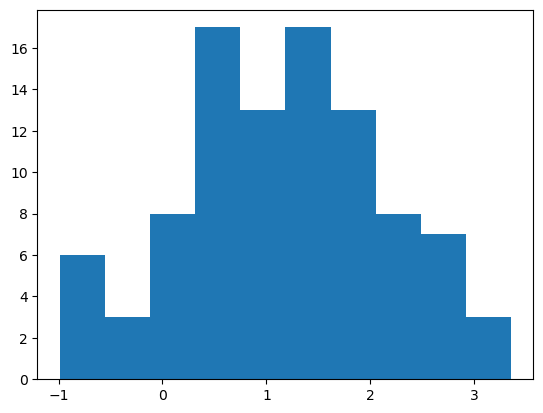

In [269]:
plt.hist(u_stat_sh_l)

In [210]:
all_sw_shuffle[4]

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 0        0.0  162            0  5821.823000    16.239782       79.0   
  1        0.0  214            1  5812.687333     9.312955       40.0   
  2        0.0  250            0  5808.786350    16.310098        7.0   
  3        1.0   59            0  5841.311267    10.028492       40.0   
  4        1.0   86            0  5867.801333     4.303260       42.0   
...        ...  ...          ...          ...          ...        ...   
  67       0.0  165            0  7305.266133    17.962872       39.0   
  68       0.0  102            2  7352.861533     2.348838       84.0   
  69       0.0  128            1  7369.182350    21.277526       92.0   
  70       0.0  139            2  7368.932267    18.639969       89.0   
  71       0.0  315            1  7309.017067     2.405896       50.0   

      trial_index  switch  index_within  switch_trial  switch_trial_frac  \
0 0             4    -1.0             2           2.0           0.133333   
  1             4     1.0             2           2.0           0.133333   
  2             4     1.0             2           2.0           0.133333   
  3             5    -1.0             2           2.0           0.200000   
  4             5     1.0             2           2.0           0.200000   
...           ...     ...           ...           ...                ...   
  67           23     1.0            13          13.0           0.866667   
  68           23     1.0            13          13.0           0.866667   
  69           23     1.0            13          13.0           0.866667   
  70           23     1.0            13          13.0           0.866667   
  71           23     1.0            13          13.0           0.866667   

      pre_ntrials_in_segment  post_ntrials_in_segment  
0 0                        2                       13  
  1                        2                        6  
  2                        2                       13  
  3                        2                        8  
  4                        2                        8  
...                      ...                      ...  
  67                       1                        2  
  68                      13                        2  
  69                      13                        2  
  70                      13                        2  
  71                      13                        2  

[72 rows x 13 columns]

In [154]:
int_con_sim_onett_overlap_and_sw_not_co

,48,53,54,58,65,68,69,84,85,87,...,325,330,338,343,345,349,351,352,357,358
46,0.000000,0.083333,0.066667,0.000000,0.153846,0.307692,0.533333,0.062500,0.142857,0.071429,...,0.466667,0.076923,0.000000,0.083333,0.285714,0.066667,0.083333,0.133333,0.071429,0.000000
48,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.142857,0.000000,0.000000
53,0.000000,1.000000,0.000000,0.166667,0.000000,0.111111,0.066667,0.000000,0.000000,0.142857,...,0.071429,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.250000,0.142857,0.000000
65,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.125000,0.000000,0.100000,0.000000,...,0.214286,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000
68,0.000000,0.111111,0.000000,0.000000,0.000000,1.000000,0.176471,0.076923,0.083333,0.000000,...,0.187500,0.000000,0.000000,0.000000,0.071429,0.083333,0.111111,0.076923,0.090909,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.000000,0.125000,0.090909,0.250000,0.000000,0.083333,0.055556,0.181818,0.090909,0.000000,...,0.000000,0.250000,0.100000,0.285714,0.076923,1.000000,0.125000,0.300000,0.000000,0.000000
351,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.125000,0.000000,...,0.071429,0.000000,0.000000,0.000000,0.000000,0.125000,1.000000,0.250000,0.142857,0.000000
352,0.142857,0.250000,0.083333,0.222222,0.000000,0.076923,0.111111,0.076923,0.181818,0.090909,...,0.117647,0.100000,0.090909,0.111111,0.071429,0.300000,0.250000,1.000000,0.090909,0.000000
357,0.000000,0.142857,0.100000,0.000000,0.000000,0.090909,0.058824,0.000000,0.000000,0.111111,...,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.090909,1.000000,0.285714


In [152]:
int_con_sim_onett_overlap_and_cosw

,95,169,183,187,217,228,241,251,266,268,...,310,318,322,330,332,338,349,351,352,357
48,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
68,0.000000,0.416667,0.000000,0.181818,0.000000,0.000000,0.000000,0.0,0.000000,0.076923,...,0.000000,0.166667,0.000000,0.000000,0.285714,0.000000,0.083333,0.111111,0.076923,0.090909
85,0.071429,0.142857,0.166667,0.200000,0.076923,0.090909,0.100000,0.0,0.083333,0.181818,...,0.000000,0.083333,0.300000,0.111111,0.000000,0.000000,0.090909,0.125000,0.181818,0.000000
86,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.125000,...,0.000000,0.000000,0.125000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
87,0.076923,0.071429,0.000000,0.000000,0.083333,0.000000,0.000000,0.0,0.000000,0.000000,...,0.333333,0.090909,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.090909,0.111111
98,0.111111,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99,0.250000,0.066667,0.166667,0.090909,0.166667,0.333333,0.000000,0.0,0.083333,0.000000,...,0.083333,0.083333,0.083333,0.111111,0.000000,0.100000,0.000000,0.000000,0.083333,0.100000
112,0.000000,0.076923,0.250000,0.111111,0.090909,0.111111,0.000000,0.0,0.000000,0.100000,...,0.000000,0.000000,0.100000,0.142857,0.200000,0.000000,0.000000,0.166667,0.000000,0.285714
125,0.250000,0.142857,0.000000,0.200000,0.076923,0.000000,0.222222,0.0,0.083333,0.181818,...,0.000000,0.083333,0.300000,0.111111,0.142857,0.100000,0.200000,0.000000,0.181818,0.000000
130,0.200000,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.0,0.111111,0.000000,...,0.250000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857


In [135]:
int_con_sim_onett.loc[overlap_and_cosw_ind]

ValueError: Cannot index with multidimensional key

In [128]:
overlap_and_co_sw_ind

array([[ 86, 169],
       [ 86, 187],
       [ 86, 322],
       [169, 187],
       [169, 322],
       [187, 322],
       [ 68,  95],
       [ 85, 260],
       [ 48, 349],
       [ 98, 266],
       [ 98, 269],
       [266, 269],
       [134, 347],
       [283, 357],
       [206, 322],
       [206, 354],
       [322, 354],
       [196, 288],
       [196, 310],
       [288, 310],
       [111, 113],
       [111, 163],
       [111, 183],
       [113, 163],
       [113, 183],
       [112, 183],
       [112, 330],
       [183, 330],
       [213, 217],
       [213, 318],
       [217, 318],
       [156, 325],
       [156, 358],
       [325, 358],
       [ 99, 228],
       [ 99, 268],
       [ 99, 352],
       [112, 241],
       [112, 251],
       [112, 332],
       [112, 338],
       [112, 351],
       [125, 268],
       [125, 285],
       [130, 268],
       [130, 352],
       [228, 268],
       [228, 352],
       [241, 251],
       [241, 332],
       [241, 338],
       [241, 351],
       [251,

In [120]:
trial_ind_dist_binary

array([[ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [110]:
all_sw_with_inh_change_one_onoff

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total,inh_fr_change,selected_inh_fr_change,fit_var_ratio,sparsity,mean
2,0.0,119,0,5806.953855,4.117201,4.135941,4,1.0,2,2.0,...,0.400000,0.400000,0.400000,0.200000,0.133333,2.806326,2.711275,0.000000e+00,1.939010,3.097497
3,0.0,316,1,5812.825286,9.187245,40.459715,4,1.0,2,2.0,...,0.800000,0.733333,0.533333,0.133333,0.066667,1.037309,1.688346,0.000000e+00,2.790211,3.718810
8,1.0,86,0,5868.064435,6.232205,42.686174,5,1.0,2,2.0,...,0.800000,0.700000,0.500000,0.300000,0.100000,-0.245773,-1.360544,3.326453e-32,2.260550,1.825884
9,1.0,169,0,5841.701165,6.939631,40.974501,5,1.0,2,2.0,...,0.800000,0.800000,0.600000,0.300000,0.200000,-0.896125,-0.104007,6.451404e-01,2.713247,5.329210
10,1.0,187,0,5868.575197,7.280078,44.171039,5,1.0,2,2.0,...,0.800000,0.800000,0.600000,0.600000,0.100000,-0.038516,-0.643202,7.184633e-01,4.064200,10.290218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.0,139,2,7368.728568,15.598707,87.770055,23,1.0,13,13.0,...,0.133333,0.133333,0.133333,0.133333,0.066667,0.141126,-2.399120,6.986965e-01,1.825887,3.668858
142,0.0,156,1,7299.376800,10.009369,96.675806,23,1.0,13,13.0,...,0.133333,0.133333,0.066667,0.066667,0.066667,1.426726,3.490841,7.420100e-01,8.548489,0.368674
143,0.0,250,0,7301.296239,10.531887,9.124525,23,1.0,13,13.0,...,0.133333,0.133333,0.066667,0.066667,0.066667,-5.316055,-0.319711,7.218322e-01,2.048883,1.039669
144,0.0,315,1,7308.976848,2.474130,49.979202,23,1.0,13,13.0,...,0.133333,0.133333,0.133333,0.133333,0.066667,-0.400074,-0.110615,5.515486e-01,1.359192,2.427050


In [ ]:
have_sw_and_overlap_pairs=

In [ ]:
cosw_and_overlap_pairs = 

In [99]:
sw_sim_onett_peruid

,46.0,48.0,53.0,54.0,58.0,62.0,65.0,68.0,69.0,70.0,...,343.0,345.0,347.0,348.0,349.0,351.0,352.0,354.0,357.0,358.0
46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
53.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
54.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
352.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
354.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
357.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [97]:
pair1,pair2=np.nonzero(ma)
ind_pairs = index_intersect[pair1],index_intersect[pair2]

In [85]:
index_intersect = pf_overlap_onett_binary.index.intersection(int_con_sim_onett.index)
pf_overlap_onett_binary.loc[index_intersect,index_intersect] * int_con_sim_onett.loc[index_intersect,index_intersect]




,39.0,40.0,42.0,46.0,47.0,48.0,49.0,50.0,52.0,53.0,...,350.0,351.0,352.0,353.0,354.0,355.0,357.0,358.0,359.0,360.0
39.0,1.000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000,0.000000,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.181818,0.071429,0.125000,0.000000,0.000000,0.000000,0.250000
40.0,0.000,1.000000,0.142857,0.000000,0.100000,0.000000,0.000,0.083333,0.000000,0.090909,...,0.000000,0.142857,0.071429,0.066667,0.000000,0.166667,0.090909,0.153846,0.000000,0.000000
42.0,0.000,0.142857,1.000000,0.066667,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,...,0.411765,0.333333,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000
46.0,0.000,0.000000,0.066667,1.000000,0.000000,0.090909,0.125,0.000000,0.000000,0.000000,...,0.111111,0.142857,0.153846,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000
47.0,0.000,0.100000,0.000000,0.000000,1.000000,0.000000,0.000,0.000000,0.111111,0.000000,...,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.000000,0.166667,0.058824,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355.0,0.125,0.166667,0.000000,0.000000,0.000000,0.235294,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.142857,0.000000,0.173913,1.000000,0.000000,0.000000,0.000000,0.000000
357.0,0.000,0.090909,0.000000,0.000000,0.000000,0.090909,0.125,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.071429,0.142857,0.000000,0.000000,1.000000,0.250000,0.117647,0.000000
358.0,0.000,0.153846,0.000000,0.000000,0.166667,0.153846,0.000,0.066667,0.076923,0.153846,...,0.000000,0.000000,0.125000,0.357143,0.000000,0.000000,0.250000,1.000000,0.000000,0.066667
359.0,0.000,0.000000,0.000000,0.000000,0.058824,0.187500,0.000,0.000000,0.058824,0.187500,...,0.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.117647,0.000000,1.000000,0.000000


,39,40,42,46,47,48,49,50,52,53,...,350,351,352,353,354,355,357,358,359,360
39,1.000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.333333,0.000000,...,0.062500,0.000000,0.000000,0.181818,0.071429,0.125000,0.000000,0.000000,0.000000,0.250000
40,0.000,1.000000,0.142857,0.000000,0.100000,0.000000,0.000000,0.083333,0.000000,0.090909,...,0.111111,0.142857,0.071429,0.066667,0.000000,0.166667,0.090909,0.153846,0.266667,0.000000
42,0.000,0.142857,1.000000,0.066667,0.153846,0.000000,0.000000,0.214286,0.071429,0.142857,...,0.411765,0.333333,0.187500,0.176471,0.375000,0.041667,0.066667,0.266667,0.150000,0.062500
46,0.125,0.000000,0.066667,1.000000,0.000000,0.090909,0.125000,0.083333,0.222222,0.000000,...,0.111111,0.142857,0.153846,0.142857,0.058824,0.000000,0.000000,0.000000,0.055556,0.000000
47,0.000,0.100000,0.153846,0.000000,1.000000,0.100000,0.142857,0.200000,0.111111,0.222222,...,0.055556,0.153846,0.076923,0.153846,0.133333,0.111111,0.000000,0.166667,0.058824,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.125,0.166667,0.041667,0.000000,0.111111,0.235294,0.058824,0.100000,0.111111,0.235294,...,0.074074,0.041667,0.142857,0.190476,0.173913,1.000000,0.050000,0.043478,0.217391,0.222222
357,0.000,0.090909,0.066667,0.000000,0.000000,0.090909,0.125000,0.000000,0.000000,0.000000,...,0.176471,0.142857,0.071429,0.142857,0.000000,0.050000,1.000000,0.250000,0.117647,0.000000
358,0.000,0.153846,0.266667,0.000000,0.166667,0.153846,0.000000,0.066667,0.076923,0.153846,...,0.210526,0.266667,0.125000,0.357143,0.166667,0.043478,0.250000,1.000000,0.294118,0.066667
359,0.000,0.266667,0.150000,0.055556,0.058824,0.187500,0.142857,0.052632,0.058824,0.187500,...,0.285714,0.277778,0.375000,0.150000,0.086957,0.217391,0.117647,0.294118,1.000000,0.111111


In [66]:
diff

0.025006887138313713

In [67]:
diff_pf

0.03019189959988

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

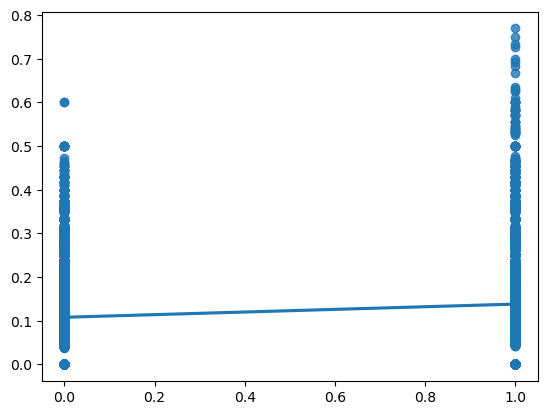

In [57]:
sns.regplot(pf_bin_flatten,int_con_sim_onett_flatten)

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

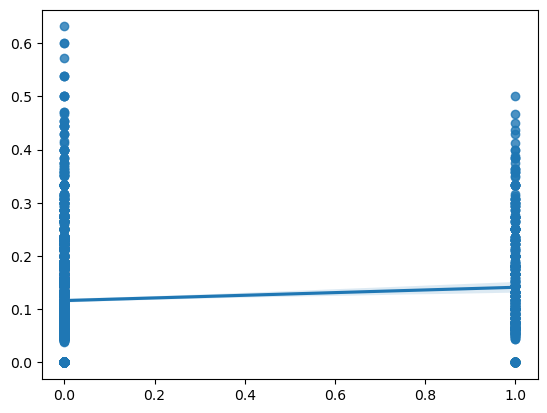

In [68]:
sns.regplot(sw_sim_onett_peruid_flatten,int_con_sim_onett_flatten_sw)

# overlapping place fields, both have pop up, whether pop up occur same trial or different trial, compare int similarity

In [73]:
all_sw_with_inh_change_one

,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total,inh_fr_change,selected_inh_fr_change,fit_var_ratio,sparsity,mean
0,both,65,1,5722.299791,40.329525,24.561733,2,-1.0,1,2.0,...,0.880000,0.320000,0.040000,0.000000,0.000000,-0.612645,-2.199061,6.873629e-01,1.649509,5.641601
1,0.0,109,0,NaN,NaN,NaN,4,-1.0,2,2.0,...,0.600000,0.200000,0.133333,0.066667,0.000000,4.941680,9.994394,6.518911e-32,3.460777,1.621692
2,0.0,119,0,5806.953855,4.117201,4.135941,4,1.0,2,2.0,...,0.400000,0.400000,0.400000,0.200000,0.133333,2.806326,2.711275,0.000000e+00,1.939010,3.097497
3,0.0,316,1,5812.825286,9.187245,40.459715,4,1.0,2,2.0,...,0.800000,0.733333,0.533333,0.133333,0.066667,1.037309,1.688346,0.000000e+00,2.790211,3.718810
4,0.0,321,1,5812.664527,9.607960,39.908798,4,-1.0,2,2.0,...,0.533333,0.000000,0.000000,0.000000,0.000000,1.216957,2.312022,7.908705e-01,2.766157,3.504064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,156,1,7299.376800,10.009369,96.675806,23,1.0,13,13.0,...,0.133333,0.133333,0.066667,0.066667,0.066667,1.426726,3.490841,7.420100e-01,8.548489,0.368674
143,0.0,250,0,7301.296239,10.531887,9.124525,23,1.0,13,13.0,...,0.133333,0.133333,0.066667,0.066667,0.066667,-5.316055,-0.319711,7.218322e-01,2.048883,1.039669
144,0.0,315,1,7308.976848,2.474130,49.979202,23,1.0,13,13.0,...,0.133333,0.133333,0.133333,0.133333,0.066667,-0.400074,-0.110615,5.515486e-01,1.359192,2.427050
145,0.0,325,0,7301.460144,14.864652,9.779967,23,-1.0,13,13.0,...,0.066667,0.000000,0.000000,0.000000,0.000000,-3.284193,-2.982450,9.000646e-01,3.597986,8.261224


In [74]:
field_dist_per_sw = all_sw_with_inh_change_one['field_pos'].values[:,None] - all_sw_with_inh_change_one['field_pos'].values[None,:]
field_dist_per_sw = np.abs(field_dist_per_sw)




In [75]:
field_dist_per_sw

array([[ 0.        ,         nan, 20.42579203, ..., 25.41746924,
        14.78176624, 15.40990208],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [20.42579203,         nan,  0.        , ..., 45.84326128,
         5.64402579,  5.01588995],
       ...,
       [25.41746924,         nan, 45.84326128, ...,  0.        ,
        40.19923549, 40.82737133],
       [14.78176624,         nan,  5.64402579, ..., 40.19923549,
         0.        ,  0.62813584],
       [15.40990208,         nan,  5.01588995, ..., 40.82737133,
         0.62813584,  0.        ]])

In [267]:
diff

0.10456125075667114

In [264]:
sw_sim_onett_peruid

3.0    31.0   34.0   35.0   36.0   37.0   38.0   39.0   40.0   \
within_1 3.0      1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         31.0     0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         34.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
         35.0     0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
         36.0     0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
         454.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         456.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         459.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         479.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         480.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                43.0   ...  437.0  440.0  443.0  448.0  452.0  454.0  456.0  \
within_1 3.0      0.0  ...    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
         31.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         34.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         35.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         36.0     0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...               ...  ...    ...    ...    ...    ...    ...    ...    ...   
         454.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
         456.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
         459.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         479.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
         480.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                459.0  479.0  480.0  
within_1 3.0      0.0    0.0    0.0  
         31.0     0.0    0.0    0.0  
         34.0     0.0    0.0    0.0  
         35.0     0.0    0.0    0.0  
         36.0     0.0    0.0    0.0  
...               ...    ...    ...  
         454.0    0.0    0.0    0.0  
         456.0    0.0    0.0    0.0  
         459.0    1.0    0.0    0.0  
         479.0    0.0    1.0    0.0  
         480.0    0.0    0.0    1.0  

[149 rows x 149 columns]

In [263]:
int_con_sim_onett

,3,27,29,30,31,32,33,34,35,37,...,456,458,459,466,468,474,475,476,479,480
3,1.000000,0.000000,0.263158,0.050000,0.181818,0.055556,0.200000,0.142857,0.076923,0.037037,...,0.000000,0.000000,0.181818,0.157895,0.133333,0.166667,0.190476,0.187500,0.142857,0.086957
27,0.000000,1.000000,0.150000,0.111111,0.136364,0.125000,0.000000,0.071429,0.041667,0.080000,...,0.076923,0.000000,0.086957,0.105263,0.066667,0.000000,0.090909,0.000000,0.071429,0.090909
29,0.263158,0.150000,1.000000,0.160000,0.133333,0.125000,0.130435,0.142857,0.100000,0.161290,...,0.095238,0.000000,0.214286,0.200000,0.086957,0.100000,0.269231,0.080000,0.043478,0.222222
30,0.050000,0.111111,0.160000,1.000000,0.068966,0.090909,0.277778,0.050000,0.152574,0.064516,...,0.052632,0.071429,0.192308,0.000000,0.157895,0.000000,0.153846,0.043478,0.000000,0.153846
31,0.181818,0.136364,0.133333,0.068966,1.000000,0.115385,0.120000,0.130435,0.090909,0.117647,...,0.086957,0.052632,0.125000,0.230769,0.227273,0.263158,0.206897,0.318182,0.181818,0.060606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,0.166667,0.000000,0.100000,0.000000,0.263158,0.062500,0.000000,0.000000,0.000000,0.040000,...,0.000000,0.000000,0.090909,0.176471,0.153846,1.000000,0.095238,0.133333,0.076923,0.095238
475,0.190476,0.090909,0.269231,0.153846,0.206897,0.120000,0.285714,0.190476,0.097727,0.156250,...,0.200000,0.055556,0.166667,0.192308,0.181818,0.095238,1.000000,0.400000,0.086957,0.214286
476,0.187500,0.000000,0.080000,0.043478,0.318182,0.000000,0.235294,0.055556,0.138393,0.107143,...,0.125000,0.083333,0.074074,0.190476,0.250000,0.133333,0.400000,1.000000,0.117647,0.120000
479,0.142857,0.071429,0.043478,0.000000,0.181818,0.055556,0.058824,0.066667,0.083333,0.037037,...,0.153846,0.111111,0.083333,0.100000,0.133333,0.076923,0.086957,0.117647,1.000000,0.086957


In [262]:
sw_sim_onett_peruid_flatten

array([], dtype=float64)

In [ ]:
int_con_sim_onett_flatten

pwa.label_difference_grouped_by_coswitch(label_sim_one,co_sw_sim_one)

In [226]:
sw_sim_allonoff_w1

3.0    31.0   34.0   35.0   36.0   37.0   38.0   39.0   \
1    within_1 3.0      1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
              31.0     0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
              34.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
              35.0     0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
              36.0     0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
both within_1 468.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
              475.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
              476.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
              479.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
              480.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                     40.0   43.0   ...  434.0  439.0  442.0  446.0  451.0  \
1    within_1 3.0      0.0    0.0  ...    NaN    NaN    NaN    NaN    NaN   
              31.0     0.0    0.0  ...    NaN    NaN    NaN    NaN    NaN   
              34.0     0.0    0.0  ...    NaN    NaN    NaN    NaN    NaN   
              35.0     0.0    0.0  ...    NaN    NaN    NaN    NaN    NaN   
              36.0     0.0    0.0  ...    NaN    NaN    NaN    NaN    NaN   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
both within_1 468.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
              475.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
              476.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
              479.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   
              480.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0   

                     455.0  463.0  468.0  475.0  476.0  
1    within_1 3.0      NaN    NaN    NaN    NaN    NaN  
              31.0     NaN    NaN    NaN    NaN    NaN  
              34.0     NaN    NaN    NaN    NaN    NaN  
              35.0     NaN    NaN    NaN    NaN    NaN  
              36.0     NaN    NaN    NaN    NaN    NaN  
...                    ...    ...    ...    ...    ...  
both within_1 468.0    0.0    0.0    0.0    0.0    0.0  
              475.0    0.0    0.0    0.0    0.0    0.0  
              476.0    0.0    0.0    0.0    0.0    0.0  
              479.0    0.0    0.0    0.0    0.0    0.0  
              480.0    0.0    0.0    0.0    0.0    0.0  

[512 rows x 218 columns]

In [225]:
sw_sim_allonoff_w1.loc[1].sum(axis=1) > 1

within_1  3.0       True
          31.0     False
          34.0     False
          35.0     False
          36.0     False
                   ...  
          454.0     True
          456.0    False
          459.0    False
          479.0     True
          480.0    False
Length: 149, dtype: bool